In [1]:
import wrangle

import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from env import user, password, host
import env
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression,LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error,explained_variance_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import csv
#import acquire
import modeling
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

In [2]:
zillow_train,zillow_validate,zillow_test=wrangle.wrangled_file()

In [3]:
zillow_train.shape,zillow_validate.shape,zillow_test.shape

((40900, 26), (17508, 26), (14596, 26))

In [4]:
#use function to scale features and concat them back to dataframe
scaled_train,scaled_validate,scaled_test = modeling.scale_data(zillow_train,zillow_validate,zillow_test,cols=['bedroom','bathroom','age','month','taxrate'])

In [5]:
scaled_train.head(1)

,bathroom,bedroom,calculatedbathnbr,sqtft,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,propertycountylandusecode,...,propertylandusedesc,county,taxrate,month,age,bedroom_scaled,bathroom_scaled,age_scaled,month_scaled,taxrate_scaled
0,3.0,3.0,3.0,1882.0,1882.0,6037.0,3.0,33890566.0,-118154278.0,010C,...,Condominium,"Los Angeles County, CA",0.013491,5,30.0,0.0,1.0,-0.636364,0.0,0.689685


In [6]:
scaled_train.columns

Index(['bathroom', 'bedroom', 'calculatedbathnbr', 'sqtft',
       'finishedsquarefeet12', 'fips', 'fullbathcnt', 'latitude', 'longitude',
       'propertycountylandusecode', 'rawcensustractandblock', 'zipcode',
       'roomcnt', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvalue',
       'assessmentyear', 'landtaxvaluedollarcnt', 'taxamount',
       'censustractandblock', 'logerror', 'propertylandusedesc', 'county',
       'taxrate', 'month', 'age', 'bedroom_scaled', 'bathroom_scaled',
       'age_scaled', 'month_scaled', 'taxrate_scaled'],
      dtype='object')

In [8]:
features = ['bathroom', 'bedroom', 'calculatedbathnbr', 'sqtft',
       'finishedsquarefeet12', 'fips', 'fullbathcnt', 'latitude', 'longitude',
       'propertycountylandusecode', 'rawcensustractandblock', 'zipcode',
       'roomcnt', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvalue',
       'assessmentyear', 'landtaxvaluedollarcnt', 'taxamount',
       'censustractandblock', 'logerror', 'propertylandusedesc', 'county',
       'taxrate', 'month', 'age']
target = ["logerror"]
X_train = scaled_train[features]
y_train = scaled_train[target]
X_validate = scaled_validate[features]
y_validate = scaled_validate[target]
X_test = scaled_test[features]
y_test = scaled_test[target]

In [9]:
X_train.head(1)

,bathroom,bedroom,calculatedbathnbr,sqtft,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,propertycountylandusecode,...,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,propertylandusedesc,county,taxrate,month,age
0,3.0,3.0,3.0,1882.0,1882.0,6037.0,3.0,33890566.0,-118154278.0,010C,...,2016.0,37447.0,2526.0,6.037554e+13,0.112968,Condominium,"Los Angeles County, CA",0.013491,5,30.0


In [10]:
y_train.head(1)

,logerror
0,0.112968


In [11]:
#apply baseline value to train and validate
y_train["baseline_mean"] = y_train.logerror.mean()
y_train["baseline_median"] =y_train.logerror.median()
y_validate["baseline_mean"] = y_validate.logerror.mean()
y_validate["baseline_median"] =y_validate.logerror.median()

In [12]:

#calculate rmse using actual and baseline mean
def get_baseline(y_train,y_validate):
    RMSE_train_mean=mean_squared_error(y_train.logerror,y_train.baseline_mean, squared = False)
    RMSE_validate_mean=mean_squared_error(y_validate.logerror,y_validate.baseline_mean, squared = False)

    print("RMSE using Mean on \nTrain: ", round(RMSE_train_mean,8), "\nValidate: ", round(RMSE_validate_mean,8))
    print()

#calculate rmse using actual and baseline mean
    RMSE_train_median= mean_squared_error(y_train.logerror,y_train.baseline_median, squared = False)
    RMSE_validate_median= mean_squared_error(y_validate.logerror,y_validate.baseline_median, squared = False)

    print("RMSE using Median on \nTrain: ", round(RMSE_train_median,8), "\nValidate: ", round(RMSE_validate_median,8))


In [13]:
get_baseline(y_train,y_validate)

RMSE using Mean on 
Train:  0.1615296 
Validate:  0.16950059

RMSE using Median on 
Train:  0.16179988 
Validate:  0.16987772


    since rmse using mean is smaller, we use mean for baseline rmse

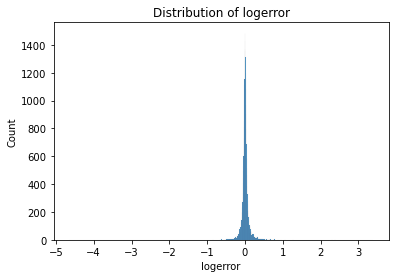

In [14]:
# peek at the distribution of my target varaible
sns.histplot(y_train.logerror)
plt.title('Distribution of logerror')
plt.show()

### Linear regression

In [21]:
def linear_regression(X_train,y_train,X_validate,y_validate):

    # create the model object
    lm = LinearRegression(normalize = True)
    
    # Fit the model
    lm.fit(X_train, y_train.logerror)
    
    # Predict y on train
    y_train['logerror_pred_lm'] = lm.predict(X_train)
    # predict validate
    y_validate['logerror_pred_lm'] = lm.predict(X_validate)
    
    # evaluate: train rmse
    rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm) ** (1/2)

    # evaluate: validate rmse
    rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm) ** (1/2)

    print("RMSE for OLS using LinearRegression\nTraining/In-Sample", round(rmse_train, 8), 
        "\nValidation/Out-of-Sample: ", round(rmse_validate, 8))

In [22]:
linear_regression(X_train,y_train,X_validate,y_validate)

ValueError: could not convert string to float: '010C'

### Lasso_lars

In [ ]:
def lasso_lars(X_train, y_train, X_validate, y_validate, alpha):
    
    # create the model object
    lars = LassoLars(alpha)

    # fit the model.
    lars.fit(X_train, y_train.logerror)

    # predict train
    y_train['logerror_pred_lars'] = lars.predict(X_train)
    # predict validate
    y_validate['logerror_pred_lars'] = lars.predict(X_validate)
    # evaluate: train rmse
    rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars)**(1/2)

    # evaluate: validate rmse
    rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars)**(1/2)

    print("RMSE for Lasso + Lars, alpha = ", i, "\nTraining/In-Sample: ", round(rmse_train, 8), 
        "\nValidation/Out-of-Sample: ", round(rmse_validate, 8))

In [ ]:
for i in range(0,5):
    lasso_lars(X_train, y_train, X_validate, y_validate, alpha = i)
    print()

#### GLM

In [ ]:
def Tweedie_regressor(X_train, y_train, X_validate, y_validate, power, alpha):

    # create the model object
    glm = TweedieRegressor(power=power, alpha=alpha)

    # fit the model to our training data.
    glm.fit(X_train, y_train.logerror)

    # predict train
    y_train['logerror_pred_glm'] = glm.predict(X_train)
    # predict validate
    y_validate['logerror_pred_glm'] = glm.predict(X_validate)
    # evaluate: train rmse
    rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_glm)**(1/2)
    # evaluate: validate rmse
    rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_glm)**(1/2)

    print("RMSE for GLM using Tweedie, power=", power, " & alpha=", alpha, 
        "\nTraining/In-Sample: ", round(rmse_train, 8), 
        "\nValidation/Out-of-Sample: ", round(rmse_validate, 8))

In [ ]:
Tweedie_regressor(X_train, y_train, X_validate, y_validate, power = 0, alpha=1)


In [ ]:
Tweedie_regressor(X_train, y_train, X_validate, y_validate, power = 0, alpha = 0)

### Polynomial Regression

In [ ]:
def polynomial_regression(X_train, y_train, X_validate, y_validate, degree):
    # make the polynomial features to get a new set of features
    pf = PolynomialFeatures(degree= degree)
    
    # fit and transform X_train_scaled
    X_train_degree2 = pf.fit_transform(X_train)
    

    # transform X_validate_scaled 
    X_validate_degree2 = pf.transform(X_validate)

    # create the model object
    lm2 = LinearRegression(normalize=True)

    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series! 
    lm2.fit(X_train_degree2, y_train.logerror)

    # predict train
    y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)

    # evaluate: train rmse
    rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2)**(1/2)

    # predict validate
    y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)

    # evaluate: validate rmse
    rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2)**(1/2)

    print("RMSE for Polynomial Model, degrees=", degree, "\nTraining/In-Sample: ", round(rmse_train,8), 
        "\nValidation/Out-of-Sample: ", round(rmse_validate,8))

In [17]:
polynomial_regression(X_train, y_train, X_validate, y_validate, degree = 1)

NameError: name 'polynomial_regression' is not defined

In [18]:
polynomial_regression(X_train, y_train, X_validate, y_validate, degree = 2)

NameError: name 'polynomial_regression' is not defined

In [19]:
polynomial_regression(X_train, y_train, X_validate, y_validate, degree = 3)

NameError: name 'polynomial_regression' is not defined

    Best model is Polynomial regression, degree 2
    We will use this model in our unseen sample to predict logerror

In [ ]:
def test_prediction(X_test,y_test):

    lars = LassoLars(alpha=0)
    lars.fit(X_test, y_test.logerror)
    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series! 
    y_test['logerror_pred_lars'] = lars.predict(X_test)
     # predict test

    # evaluate: test rmse
    rmse_test = mean_squared_error(y_test.logerror, y_test.logerror_pred_lars)**(1/2)

    print("RMSE for Linear Regression Model,","\ntest: ", rmse_test, "\nr^2: ", explained_variance_score(y_test.logerror,
                                           y_test.logerror_pred_lars))

In [ ]:
#test predict

test_prediction(X_test,y_test)